![nn](img/housing_dataset_img.jpg)

## [머신러닝] Kaggle - 주택 가격 예측 (회귀, Regression)
 - 분석 결과 파일 : ml_regression/housing_price_predict.ipynb <br><br>

> #### Housing Price Prediction Dataset  <br>
- 데이터는 다음의 링크에서 확인할 수 있습니다. → [링크](https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data) <br><br>

> #### 다음 6개의 변수를 가지고 있으며 `Price`를 예측하는 것이 목적입니다.<br>
- `SquareFeet` : 평방미터(평수)<br>
- `Bedrooms` : 침실(수)<br>
- `Bathrooms` : 욕실(수)<br>
- `Neighborhood` : 동네 유형(Rural, Suburb, Urban)<br>
- `YearBuilt` : 건설 연도<br>
- `Price` : 주택 가격 <br><br>

> #### 사용한 Model (6개):
- 선형회귀 : LinearRegression, Lasso <br>
- 앙상블모델 : RandomForestRegressor, GradientBoostingRegressor, xgboost <br>
- 거리 기반 : k-NN <br><br>

> #### 성능 평가 지표 :
- R-Squared, RMSE


> #### 결과 요약
- 주택 가격의 단위가 크기 때문에 정확한 예측은 어려우나 앞2자리는 유사하게 예측한 것을 확인할 수 있었습니다.<br>
- 가장 성능이 좋았던 모델은 선형 회귀(Linear Regression)로 다음과 같은 성능을 보입니다.<br>
      (R2는 1에 가까울수록, RMSE는 0에 가까울수록 성능이 좋음)<br>
    - R2_score: 0.5692276886706162    |    RMSE: 49972.695984341706 <br>
- 상관관계 분석을 통해 가격(Price)에 평수(SquareFeet)가 0.75로 유의미한 관계가 있었고 나머지는 관계가 적었습니다.<br>
- 이 부분의 영향으로 예측 성능이 낮았을 것으로 판단됩니다. <br>

> #### 성능 추가 개선을 위한 방법
- 모델 측면 :
   - 여러 모델을 적용하여 가장 좋은 성능을 보이는 모델을 선택합니다.
   - k-Fold(교차검증) 등을 이용하여 데이터에 알맞는 기법을 선택해볼 수 있습니다.
   - 하이퍼 파라미터 튜닝(n_estimator, learning rate)/그리드 서치 등을 이용하여 최적의 파라미터를 찾는 방법을 사용할 수 있습니다.
- 데이터 측면 :
   - 가격 결정에 유의미한 데이터를 좀 더 추가할 수 있습니다(크롤링, 외부데이터 추가 수집 등).
   - 데이터 스케일링(Data Scaling), 표준화(Standardization) 등을 통해 데이터를 공통된 범위로 조정할 수 있습니다.

# 1. 라이브러리 import & 데이터 Load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('housing_price_dataset.csv')
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


# 2. EDA (Exploratory Data Analysis)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [4]:
# 모든 변수 결측치 확인
df.isnull().sum()

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

In [5]:
# object 타입(동네 유형) value 개수
df['Neighborhood'].value_counts()

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

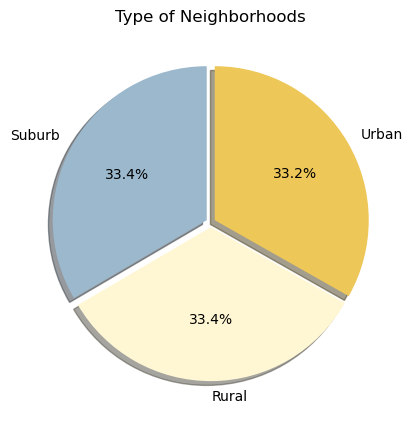

In [6]:
# Pie Chart로 확인
plt.figure(figsize=(5, 5))
explode = [0.03, 0.03, 0.03]
colors = ['#9BB8CD', '#FFF7D4', '#EEC759']

plt.pie(df["Neighborhood"].value_counts(), labels=df["Neighborhood"].value_counts().index, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors, shadow=True)
plt.title('Type of Neighborhoods')
plt.show()

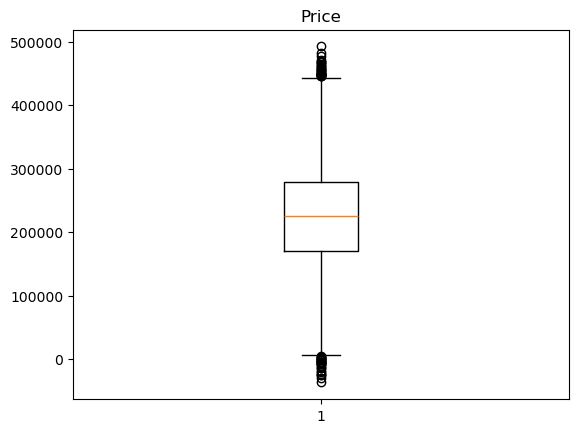

In [7]:
# Price 분포 확인
plt.boxplot(df["Price"])
plt.title('Price')
plt.show()

In [8]:
# 데이터 전체 통계
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


## 3. 데이터 전처리

In [9]:
# 라벨인코딩 (object -> int형 변환)
LabelEncoder = LabelEncoder()
df['Neighborhood'] = LabelEncoder.fit_transform(df['Neighborhood'])
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,0,1969,215355.283618
1,2459,3,2,0,1980,195014.221626
2,1860,2,1,1,1970,306891.012076
3,2294,2,1,2,1996,206786.787153
4,2130,5,2,1,2001,272436.239065


In [10]:
# 원핫인코딩으로 진행 시
# df = pd.get_dummies(df, dtype=int)
# df.head()

In [11]:
# 변수 간 상관관계 확인
df.corr()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
SquareFeet,1.000000,-0.002638,-0.003275,0.011186,0.000482,0.750720
Bedrooms,-0.002638,1.000000,0.007405,-0.004208,0.003147,0.072624
Bathrooms,-0.003275,0.007405,1.000000,0.001613,0.003748,0.028418
Neighborhood,0.011186,-0.004208,0.001613,1.000000,-0.000174,0.016429
YearBuilt,0.000482,0.003147,0.003748,-0.000174,1.000000,-0.002288
Price,0.750720,0.072624,0.028418,0.016429,-0.002288,1.000000


<Axes: >

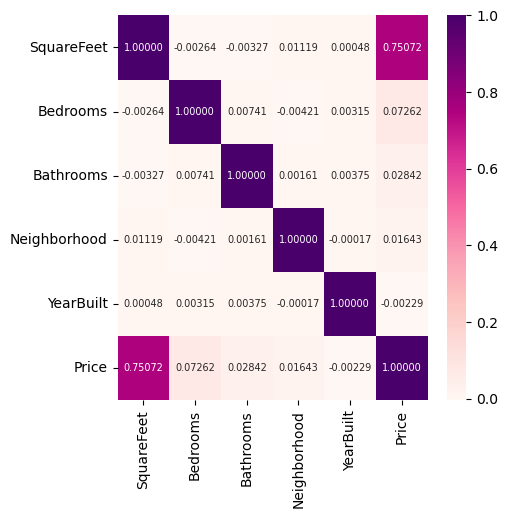

In [12]:
# Heatmap으로 상관관계 확인 
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 7}, fmt='.5f', cmap='RdPu')

## 4. 모델 학습 & 성능 평가

In [13]:
# 데이터 Train, Test 나누기
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Price', axis=1), df['Price'], test_size=0.2, random_state=1234
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000, 5) (10000, 5) (40000,) (10000,)


In [14]:
X_train.head(3)

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt
37174,2714,4,1,1,1969
29950,1333,2,2,0,1997
49833,2542,5,2,1,1969


In [15]:
y_train.head(3)

37174    318386.661622
29950    105783.099392
49833    245920.448070
Name: Price, dtype: float64

In [16]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 40000 entries, 37174 to 27439
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
40000 non-null  float64
dtypes: float64(1)
memory usage: 625.0 KB


In [17]:
models = [
    LinearRegression(),
    Lasso(random_state=1234),
    RandomForestRegressor(random_state=1234),
    GradientBoostingRegressor(random_state=1234),
    KNeighborsRegressor(),
    XGBRegressor(random_state=1234)
]

In [18]:
# best model 찾기
best_loss = None
best_model = None
best_score = None

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'    {model.__class__.__name__}')
    print(f'    R2_score: {round(r2, 4)}    |    RMSE: {round(rmse, 6)}')
    print('=' * 60)

    if best_loss != None:
        if best_score < r2:
            best_model = model
            best_score = r2
            best_loss = rmse

    else:
        best_model = model
        best_score = r2
        best_loss = rmse

print(f'\nBest Model : {best_model.__class__.__name__} \n    R2_score: {best_score}    |    RMSE: {best_loss}')

    LinearRegression
    R2_score: 0.5692    |    RMSE: 49972.695984
    Lasso
    R2_score: 0.5692    |    RMSE: 49972.709112
    RandomForestRegressor
    R2_score: 0.515    |    RMSE: 53024.117267
    GradientBoostingRegressor
    R2_score: 0.5683    |    RMSE: 50025.627991
    KNeighborsRegressor
    R2_score: 0.4745    |    RMSE: 55194.735955
    XGBRegressor
    R2_score: 0.5537    |    RMSE: 50864.618765

Best Model : LinearRegression 
    R2_score: 0.5692276886706162    |    RMSE: 49972.695984341706


In [ ]:
# 개별로 학습
# model = RandomForestRegressor()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# 성능 평가 결과 (r2, rmse)
# r2 = r2_score(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print('R2_score: ', r2)
# print('RMSE:     ', rmse)

## 5. 결과 확인

In [19]:
# best model 기준 예측값 저장
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 성능 평가 결과 (r2, rmse)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('R2_score: ', r2)
print('RMSE:     ', rmse)

# 예측값 저장
predict = pd.DataFrame({
    'Neighborhood': X_test['Neighborhood'],
    'Price': y_pred
})

R2_score:  0.5692276886706162
RMSE:      49972.695984341706


In [20]:
predict.shape

(10000, 2)

In [21]:
predict.head()

,Neighborhood,Price
20308,0,269752.578805
37706,1,226515.920428
6041,1,187048.154447
42143,0,307241.385607
23202,0,256379.404406


### Appendix. 예측결과(연속형) 값과 비교

In [22]:
# X_train 데이터셋의 y_train값 평균
train_mean_price = pd.DataFrame([X_train['Neighborhood'], y_train])
train_mean_price = train_mean_price.T
train_mean_price['Neighborhood']=train_mean_price['Neighborhood'].astype('int64')

# X_test 데이터셋의 y_test값 평균 
xtest_mean_price = pd.DataFrame([X_test['Neighborhood'], y_test])
xtest_mean_price = xtest_mean_price.T
xtest_mean_price['Neighborhood']=xtest_mean_price['Neighborhood'].astype('int64')

# 학습데이터 주택 가격 (X_train, y_train)
train_mean_price = pd.DataFrame(train_mean_price.groupby('Neighborhood')['Price'].mean())
# 테스트데이터 주택 가격 (X_test, y_test)
xtest_mean_price = pd.DataFrame(xtest_mean_price.groupby('Neighborhood')['Price'].mean())
# 예측한 주택 가격 (X_test, y_pred)
pred_df = pd.DataFrame(predict.groupby('Neighborhood')['Price'].mean())

# 가격 차이 (y_train - y_pred = price_difference_1, y_test-y_pred =  price_difference_2)
price_difference_0 = []
price_difference_1 = []
price_difference_2 = []
for i in range(len(train_mean_price+1)):
    price0 = train_mean_price['Price'][i] - xtest_mean_price['Price'][i]
    price1 = train_mean_price['Price'][i] - pred_df['Price'][i]
    price2 = xtest_mean_price['Price'][i] - pred_df['Price'][i]
    price_difference_0.append(price0)
    price_difference_1.append(price1)
    price_difference_2.append(price2)
price_difference_0 = pd.DataFrame(price_difference_0)
price_difference_1 = pd.DataFrame(price_difference_1)
price_difference_2 = pd.DataFrame(price_difference_2)

# 하나의 데이터프레임으로 결과 비교해보기
result_df = pd.concat([train_mean_price, xtest_mean_price, pred_df, price_difference_0, price_difference_1, price_difference_2], axis=1).reset_index()
result_df.columns = ['Neighborhood', 'Train Price', 'Test Price', 'Predict Price', 'Train-Test', 'Train-Predict', 'Test-Predict']
result_df['Neighborhood']=result_df['Neighborhood'].replace({0: 'Rural', 1: 'Suburb', 2: 'Urban'})

> ### 도시 유형(Neighborhood) 기준으로 평균 주택 가격 평균을 냈을 때
- Train Price(y_train) 학습 데이터 주택가격
- Test Price(y_test) 테스트 데이터 주택가격
- Predict Price(y_pred) 학습 데이터 기반 예측 결과
- Train-Test 원래 있던 50,000개 데이터를 나눠서 40,000개(X_train)과 10,000개(X_test)의 차이
- Train-Predict 머신러닝 학습(x_train, y_train) 후 예측한 결과(x_test, y_pred)의 차이
- Test-Predict 같은 데이터(X_test)의 원가격(정답, y_test)과 예측값(y_pred) 비교했을 때 차이 <br>

In [23]:
result_df

,Neighborhood,Train Price,Test Price,Predict Price,Train-Test,Train-Predict,Test-Predict
0,Rural,224033.079095,224355.486592,223576.574069,-322.407497,456.505026,778.912523
1,Suburb,223477.215290,222283.434954,222341.663788,1193.780336,1135.551503,-58.228834
2,Urban,227249.379884,226835.262010,224942.849065,414.117874,2306.530819,1892.412945
